# Transient Flow, Mulitple-Layer Aquifer 

The figure below is a map and cross section of an aquifer system.  

![](drawing_P-12.png)

Two well fields operate in the area; well field A pumping $10 \times 10^{6} \frac{m^3}{yr}$ and a well field B pumping $16 \times 10^{6} \frac{m^3}{yr}$ All the intake screens in well field B are below the semipervious layer.  A new wellfield, C is planned, with an annual withdrawl of $15 \times 10^{6} \frac{m^3}{yr}$ and, if possible, up to $25 \times 10^{6} \frac{m^3}{yr}$.

Use MODFLOW to evaluate the feasibility of the proposed pumping rates for well field C.  The river itself should not serve as a water source because the water rights are already apportioned (i.e. someone else owns the water).

The plan view layout and the 5-layer conceptualization are shown below.  

![](planview.png)

The vertical discritization used is a 5-layer conceptualization to mimic the aquifer system.

![](elevationview.png)

The upper aquifer layer is unconfined and the river is represented using constant head boundaries. The next layer is a confined/unconfined layer and is where the well field A wells are screened (65-125 meters).  The aquitard is a thin layer from (60-65 meters) with spatially varying hydraulic conductivity. The lower aquifers are represented as confined in MODFLOW, with well screens as shown.  

Below we use MODFLOW to produce:

1. An equilibrium head distribution for all 5 aquifer layers in this system, with zero pumping in all wellfields.  This is a pre-development case (recharge only).
2. An equilibrium head distribution for the system with only Wellfield A active (assuming 30 years is long enough to reach equilibrium).
3. An equilibrium head distribution for the system with Wellfields A and B active at the prescribed rates. (Again assuming 30 years is long enough to reach equilibrium).
4. An equilibrium head distribution for the system with Wellfields A and B active at the prescribed rates; Wellfield C is active, but rate is increased by trial-error until gradient from river indicates flow into the aquifer.  

In [1]:
%reset -f

In [2]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

In [4]:
#dir(flopy.mf6)


In [5]:
# Workspace and Executibles
#binary = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6"  # location on MY computer of the compiled modflow program
#workarea = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/project_1" # location on MY computer to store files this example (directory must already exist)

binary = "/home/sensei/mfplayground/modflow-python/mf6.4.1_linux/bin/mf6"  # location on AWS computer of the compiled modflow program
workarea = "/home/sensei/ce-5364-webroot/mfexperiments/example_3" # location on MY computer to store files this example (directory must already exist)

# Set Simulation Name
name = "example_3"
#modelname=name

##### FLOPY Build simulation framework ####
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name=binary, version="mf6", sim_ws=workarea
)

In [6]:
# Set Time Structure
Time_Units="YEARS"

# Multiple stress periods
nper = 4 # how many periods
# perlen = how long each one in problem time units
# nstp =  how many steps in each stress period
# tsmult = time step multiplier
# perioddata = [(perlen,nstp,tsmult),(perlen,nstp,tsmult),(perlen,nstp,tsmult) ... repeat for each stress period]

perioddata = [(30.0,30,1),(30.0,30,1),(30.0,30,1),(30.0,30,1)]

##### FLOPY Build time framework ##########
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units=Time_Units, nper=nper, perioddata=perioddata,
)

In [7]:
# Set Iterative Model Solution (choose solver parameters)
# about IMS see: https://water.usgs.gov/nrp/gwsoftware/ModelMuse/Help/sms_sparse_matrix_solution_pac.htm
# using defaults see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfims.html

##### FLOPY Build IMS framework ###########
ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE")

In [8]:
# Set Model Name (using same base name as the simulation)
model_nam_file = "{}.nam".format(name)

##### FLOPY Build Model Name framework ####
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

In [9]:
# Define The Grid
Nlay = 5 #number layers
Nrow = 24 #number rows
Ncol = 11 #number columns
# Define distances and elevations
delrow = 1000 # cell size along columns (how tall is a row)
delcol = 1000 # cell size along row (how wide is a column)
topelev = 180.0 # elevation of top of aquifer
thick = 175.0 #aquifer thickness

#bot = [topelev-thick] # bot is a list with Nlay entries
bot = np.array([125,65,60,25,0])
#print(bot)


##### FLOPY Build Model Grid framework #####
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=Nlay,nrow=Nrow,ncol=Ncol,delr=delrow,delc=delcol,top=topelev,botm=bot,
)


In [10]:
# Define initial conditions
h1 = 151.0 # 
start = h1 * np.ones((Nlay, Nrow, Ncol)) # start heads are h1 everywhere

##### FLOPY Build Initial Conditions framework ###
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

In [11]:
# Define hydraulic conductivity arrays
K1 = 2*3650.0
K2 = 2*3650.0
K3 = 0.01*3650.0
K4 = 2*3650.0
K5 = 4*3650
k = np.ones((Nlay, Nrow, Ncol)) # populate k with ones
#print(k) # check structure
k[0] = K1*np.ones((1, Nrow, Ncol))
k[1] = K2*np.ones((1, Nrow, Ncol))
k[2] = K3*np.ones((1, Nrow, Ncol)) # modify for spatial varying K this layer
for irow in range(18,Nrow):
    k[2][irow] = K2
k[3] = K4*np.ones((1, Nrow, Ncol))
k[4] = K5*np.ones((1, Nrow, Ncol))
#print(k[2]) # check structure
# Use above to build layer-by-layer spatial varying K
# need to read: to deal with Kx!=Ky

##### FLOPY Build BCF framework ######
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k, save_flows=True) 
# setting icelltype > 0 is unconfined 
# https://flopy.readthedocs.io/en/3.3.5/source/flopy.mf6.modflow.mfgwfnpf.html?highlight=icelltype#flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf.icelltype

In [12]:
# Define the storativity arrays
Sy = 0.25 # specific yield
Ss = 2.5e-4 # specific storage

sto = flopy.mf6.ModflowGwfsto(gwf, sy=Sy)

In [13]:
# Define constant head boundary conditions - these need to be supplied for each stress period
chd_rec = []
hriv = 151 # river as a boundary
for col in range(0,Ncol):
    chd_rec.append(((0, 6 , col), hriv)) # river as a boundary
#chd_rec.append(((0, 5, 5), h2))
# L,R,T,B constant head boundaries
#for layer in range(0, Nlay):
#    for row in range(0, Nrow):
#        chd_rec.append(((layer, row, 0), h1))  #left column held at h1
#        chd_rec.append(((layer, row, Ncol-1), h1)) #right column held at h1
#    for col in range(1,Ncol-1):
#        chd_rec.append(((layer, 0, col), h1)) # top row held at h1
#        chd_rec.append(((layer, Nrow-1 , col), h1)) # bottom row held at h1

stress_period_data = {0: chd_rec, 1: chd_rec, 2: chd_rec, 3: chd_rec} # dictionary same BC each stress period
        
##### FLOPY Build CHD framework #####          
chd = flopy.mf6.ModflowGwfchd(gwf,maxbound=len(chd_rec),stress_period_data=stress_period_data,save_flows=True,
)

In [14]:
# Define wellfields
#wel_rec = []
# wel_rec.append((0, 5, 5, -0e6)) # 0 Mm3/yr - use to examine recharge only
#wel_rec.append((0, 5, 5, -2114e6)) # 2,114 Mm3/yr
# Multiple Stress Periods


wel_sp1 = []
wel_sp1.append((0, 21, 5, -0.01)) #wellfieldA-upper
wel_sp1.append((1, 21, 5, -0.01)) #wellfieldA-lower
wel_sp1.append((3, 14, 6, -0.01)) #wellfieldB-upper
wel_sp1.append((4, 14, 6, -0.01)) #wellfieldB-lower
wel_sp1.append((3, 4, 6, -0.01)) #wellfieldC-upper
wel_sp1.append((4, 4, 6, -0.01)) #wellfieldC-lower

wel_sp2 = []
wel_sp2.append((0, 21, 5, -5.0e6)) #wellfieldA-upper
wel_sp2.append((1, 21, 5, -5.0e6)) #wellfieldA-lower
wel_sp2.append((3, 14, 6, -0.1)) #wellfieldB-upper
wel_sp2.append((4, 14, 6, -0.1)) #wellfieldB-lower
wel_sp2.append((3, 4, 6, -0.1)) #wellfieldC-upper
wel_sp2.append((4, 4, 6, -0.1)) #wellfieldC-lower

wel_sp3 = []
wel_sp3.append((0, 21, 5, -5.0e6)) #wellfieldA-upper
wel_sp3.append((1, 21, 5, -5.0e6)) #wellfieldA-lower
wel_sp3.append((3, 14, 6, -8.0e6)) #wellfieldB-upper
wel_sp3.append((4, 14, 6, -8.0e6)) #wellfieldB-lower
wel_sp3.append((3, 4, 6, -0.1)) #wellfieldC-upper
wel_sp3.append((4, 4, 6, -0.1)) #wellfieldC-lower

wel_sp4 = []
wel_sp4.append((0, 21, 5, -5.0e6)) #wellfieldA-upper
wel_sp4.append((1, 21, 5, -5.0e6)) #wellfieldA-lower
wel_sp4.append((3, 14, 6, -8.0e6)) #wellfieldB-upper
wel_sp4.append((4, 14, 6, -8.0e6)) #wellfieldB-lower
wel_sp4.append((3, 4, 6, -3.0e6)) #wellfieldC-upper
wel_sp4.append((4, 4, 6, -5.0e6)) #wellfieldC-lower

stress_period_data = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3, 3: wel_sp4}
#wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)



##### FLOPY Build Wellfields framework #####  
wel = flopy.mf6.ModflowGwfwel(gwf,maxbound=6,stress_period_data=stress_period_data,)

In [15]:
# Define recharge
rech_val = 0.25 #  rate as depth/year
rech_rec = rech_val * np.ones((1, Nrow, Ncol)) # set recharge top layer only

rec_sp1 = rech_rec
rec_sp2 = rech_rec
rec_sp3 = rech_rec

stress_period_data = {0: rec_sp1, 1: rec_sp2, 2: rec_sp3}

#rch = flopy.mf6.ModflowGwfrcha(gwf, maxbound=len(rech_rec),recharge=stress_period_data,)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=stress_period_data,)

#rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rech_val) # default entry format

In [16]:
# something to do with stress periods
iper = 0
ra = chd.stress_period_data.get_data(key=iper)


In [17]:
# Create the output control (`OC`) Package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]

##### FLOPY Build OC framework
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [18]:
# Write files to the directory
sim.write_simulation();

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model example_3...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package chd_0...
    writing package wel_0...
    writing package rcha_0...
    writing package oc...


In [19]:
# Attempt to run MODFLOW this model
success, buff = sim.run_simulation(silent=True, report=True)
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

179.42766115495905
179.42524150729793


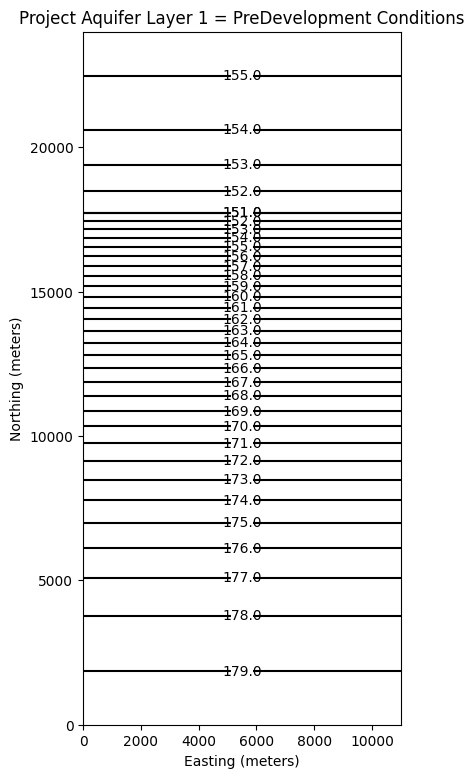

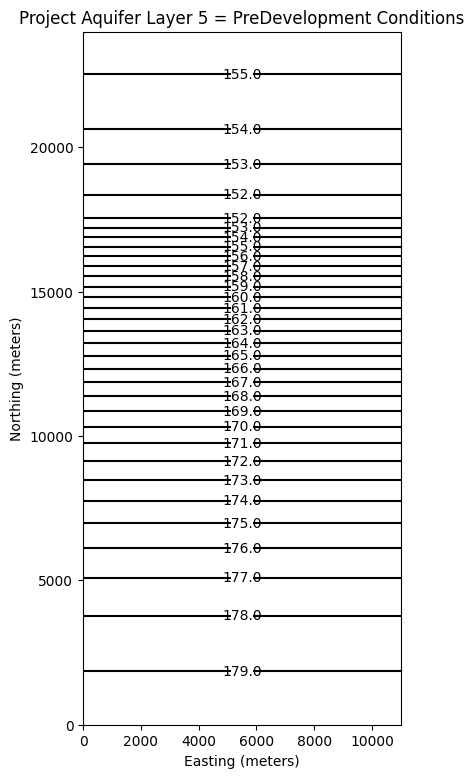

In [20]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(29, 0))
print(h[0].max())
#print(h[0])
#x = np.linspace(0, LC, Ncol )
x =  np.linspace(0, delcol*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -0., 175.0
contour_intervals = np.arange(0, 200.0, 1.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 1 = PreDevelopment Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 5

print(h[4].max())

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[4], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 5 = PreDevelopment Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

170.3240007892975
170.32146880491723


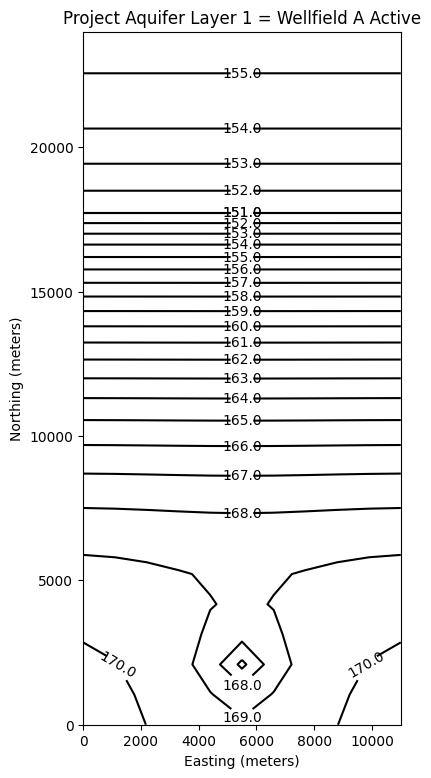

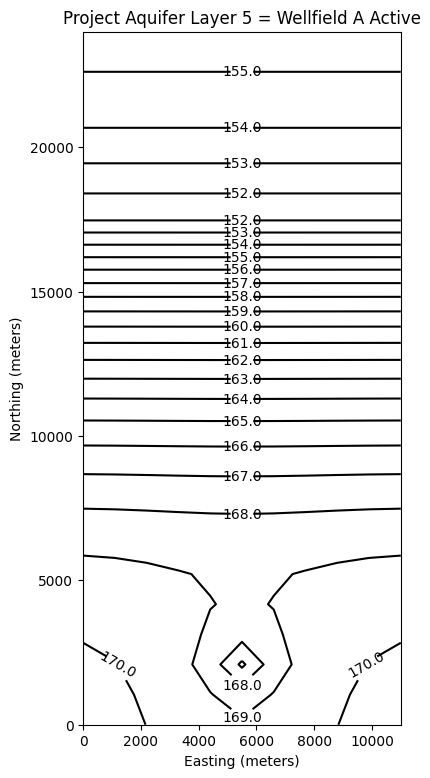

In [21]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(29, 1))
print(h[0].max())
#print(h[0])
#x = np.linspace(0, LC, Ncol )
x =  np.linspace(0, delcol*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -0., 175.0
contour_intervals = np.arange(0, 200.0, 1.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 1 = Wellfield A Active")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 5

print(h[4].max())

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[4], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 5 = Wellfield A Active")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

161.8575008612184
161.85485401337985


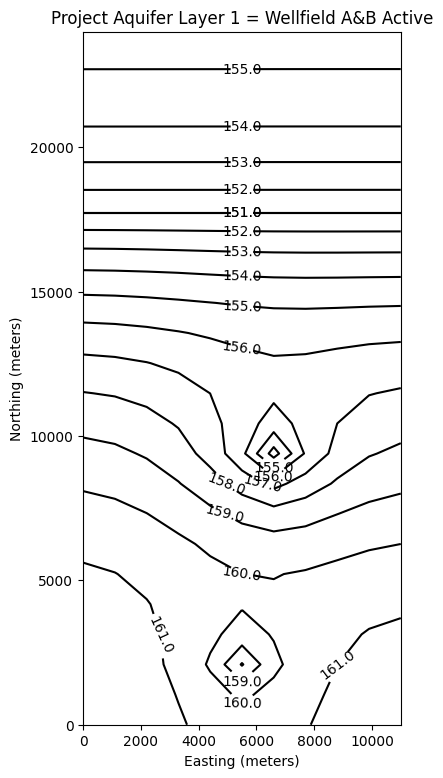

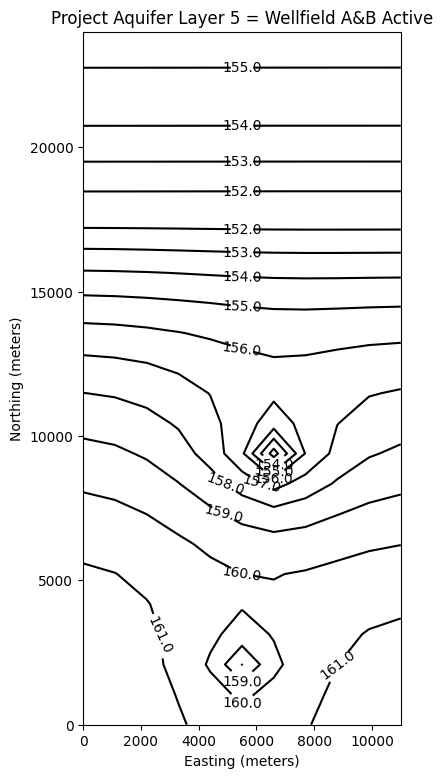

In [22]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(29, 2))
print(h[0].max())
#print(h[0])
#x = np.linspace(0, LC, Ncol )
x =  np.linspace(0, delcol*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -0., 175.0
contour_intervals = np.arange(0, 200.0, 1.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 1 = Wellfield A&B Active")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 5

print(h[4].max())

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[4], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 5 = Wellfield A&B Active")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

161.83147923607353
161.82883201930647


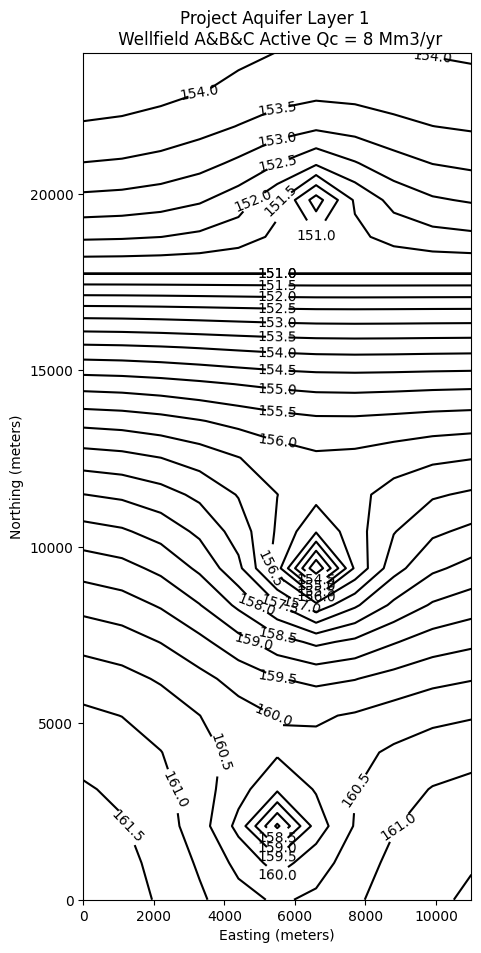

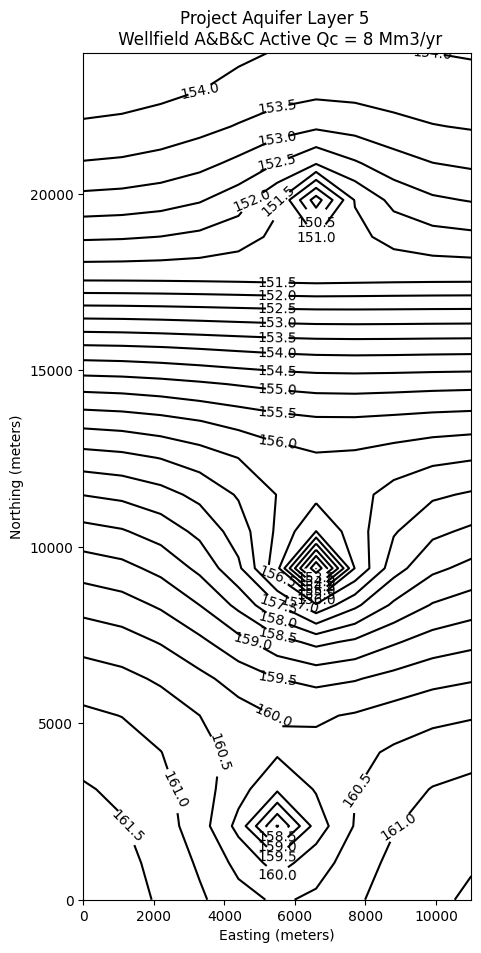

In [23]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(29, 3))
print(h[0].max())
#print(h[0])
#x = np.linspace(0, LC, Ncol )
x =  np.linspace(0, delcol*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -0., 175.0
contour_intervals = np.arange(0, 200.0, 0.50)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 1 \n Wellfield A&B&C Active Qc = 8 Mm3/yr")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 5

print(h[4].max())

fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[4], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 5 \n Wellfield A&B&C Active Qc = 8 Mm3/yr")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

So for the stated problem, wellfield C is limited to about $8~\frac{Mm^3}{yr}$ if the goal is to avoid river flow into the aquifer.

The next steps are to add stress periods according to the annual pumping schedule to examine the effect time-of-year has on the heads.

## End of Section